### Importing necessary packages

In [ ]:
# training and testing if made on google colaboratory
from google.colab import drive

drive.mount('/content/drive')

In [2]:
# !pip install pydub
# !pip install python-Levenshtein

    100% |████████████████████████████████| 51kB 4.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [0]:
# necessary imports
import os
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import cv2

from collections import OrderedDict
from pydub import AudioSegment
from scipy import signal
from Levenshtein import distance
from PIL import Image
from tqdm import tqdm_notebook
from torch.utils.data import Dataset, DataLoader, TensorDataset

### Loading data

In [0]:
# root path if remote
root_path = '/content/drive/My Drive/speech_recogniser/'

In [0]:
# # root path if local
# root_path = './'

In [0]:
data_dir = root_path + 'data/'
model_dir = root_path + "models/"

train_dir = data_dir + 'train'
valid_dir = data_dir + 'valid'

In [0]:
# helper function to resolve a file transcription
def resolve_transcription(files, transcription, relative_path = "./"):
    # our transcriptions
    transcriptions = []
    
    with open(relative_path + transcription, "r") as trans_file:
        # looping through each line from transcription
        for line in trans_file:
            # perform a single split, first match - audio source, second match - targets(text)
            match = line.split(" ", 1)
            
            # expecting two elements and filter out long seq
            if(len(match) == 2):
                
                # our audio source with full name
                audio_source = match[0] + ".flac"

                # expecting the audio source to be present
                if(audio_source not in files):
                    pass

                # append to our transcriptions
                transcriptions.append({
                    "targets" : match[1][:-1],
                    "audio" : relative_path + audio_source,
                    "image" : relative_path + match[0] + ".png"
                })
                    
    return transcriptions    

# helper function to retrieve the paths
def resolve_data(dir_path):
    dirs = os.listdir(dir_path)

    transcriptions = []
    
    for directory in dirs:
        for sub_dir in os.listdir(dir_path + "/" + directory):
            # current directory
            curr_dir = dir_path + "/" + directory + "/" + sub_dir + "/"
            
            # files including images, audio files and text
            files = os.listdir(curr_dir)
            
            # filtering files by text
            files_text = [ file for file in files if file.endswith(".txt") ]
            
            # only one single transcription per directory source
            if(len(files_text) == 1):
                # our transcription to be resolved(link between the actual text and the audio source and image if exists)
                transcription = files_text[0]
                
                # resolved transcription with audio source and spectrogram(image path)
                resolved_transcription = resolve_transcription(files, transcription, relative_path = curr_dir)
                
                # concatenate with our raw list
                transcriptions += resolved_transcription

    return transcriptions

In [0]:
# data types
data_types = {"train" : train_dir, "valid" : valid_dir}

# transcriptions holder
transcriptions = {data_type : resolve_data(data_dir) for data_type, data_dir in data_types.items()}

In [0]:
# default sampling rate
sampling_rate = 16000

# sampling chunk length
nfft = 320

# sampling length to be padded
sampling_pad = sampling_rate / nfft

# helper function to resolve an audio source file to spectrogram
def resolve_image_source(transcription, rewrite = False, interactive = False):
    # image source
    image_source = transcription["image"]
    
    # rewrite turned off and image source exists then show only
    image_save = not (not rewrite and os.path.isfile(image_source))
    
    # if not interactive and no rewriting is required then finish
    if(not (image_save or interactive)):
        return
    
    # audio source
    audio_source = transcription["audio"]
    
    if(audio_source.endswith((".flac", ".wav"))):
        raw = AudioSegment.from_file(audio_source)
    else: 
        raw = AudioSegment.from_mp3(audio_source)

    # single channel
    raw = raw.set_channels(1)
    
    # downsampling the audio source
    # raw = raw.set_frame_rate(sampling_rate)

    # retrieving data
    data = raw.get_array_of_samples()
    
    # data to numpy array
    data = np.array(data)
    
    # sample frequencies, segment times, frequencies domain output where nfft 320 => 16000 / 320 = 50 => 20ms chunk
    f, t, Sxx = signal.spectrogram(data, raw.frame_rate, nfft = nfft, nperseg = nfft, noverlap = 0)
    
    # dimensions
    row, col = Sxx.shape[0], Sxx.shape[1]

    # normalizing dimensions
    row, col = 1.0, (col / row)
    
    # dpi to match the file size
    fig = plt.figure(figsize = (col, row), dpi = Sxx.shape[0])
    fig.subplots_adjust(0, 0, 1, 1)

    plt.set_cmap("gray")
    
    ax = fig.add_subplot(1, 1, 1, frameon = False)
    ax.pcolormesh(t, f, 10 * np.log10(Sxx + 0.000001))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if(image_save):
        plt.savefig(image_source)
    
    # don't show figure if not interactive
    if(not interactive):
        plt.close(fig)

# helper function to clean the generated spectrogram
def clean_image_source(transcription):
    # image source
    image_source = transcription["image"]
    
    # check if image source exists
    if(os.path.isfile(image_source) and not os.path.isdir(image_source)):
        os.remove(image_source)
        
# helper function to resolve all audio sources file to spectrograms
def resolve_transcription_images(transcriptions, rewrite = True, clean = False):
    
    # interactive mode turned off
    plt.ioff()
    
    for transcription in transcriptions:
        
        # clean all
        if(clean):
            clean_image_source(transcription)
            
        resolve_image_source(transcription, rewrite, interactive = False)
        
    # interactive mode turned on for default behaviour
    plt.ion()

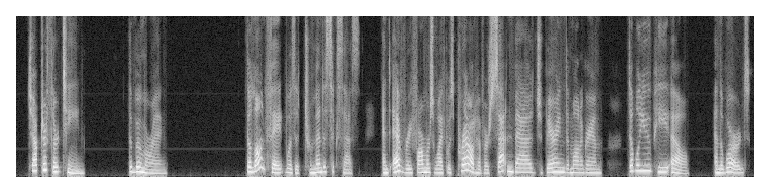

In [9]:
resolve_image_source(transcriptions["train"][0], rewrite = False, interactive = True)

Generating for each audio source and image representing the spectrogram related to the audio source

In [0]:
for key, value in transcriptions.items():
    resolve_transcription_images(transcriptions[key], rewrite = False)

#### Finding the normalization parameters and adjusting the data accordingly

In [0]:
# helper function to generate image source, single channel image to be assumed and maximum dimensions in order to pad properly
def generate_image_source(img = None, transcription = None):
    
    # image size
    img_size = None
    
    if(transcription is None and img is None):
        raise Exception("Illegal arguments provided")
    
    if(transcription is not None):
        
        try:
            
            # file to be opened
            file = open(transcription["image"], 'rb')
        
            # get the image source
            img = Image.open(file)

            # get image size
            img_size = img.size

            return np.array(img, dtype = 'float32')[:, :, 0] / 255.0, img_size
    
        except IOError:
            
            print(transcription["image"])    
            
    elif(img is not None):
        return np.array(img, dtype = 'float32')[:, :, 0] / 255.0
    
    return None, None

def per_sample(sample, mean):
    # flatten the array
    sample = sample.flatten()
        
    return ((sample - mean) ** 2).sum(), len(sample)

def generate_data_properties(transcriptions):
    # mean and std
    mean, std = 0, 0
    
    # max width, height
    width, height = 0, 0
    
    # calculating mean of images
    for transcription in tqdm_notebook(transcriptions):
        
        img, img_size = generate_image_source(transcription = transcription)
        
        # remove if none
        if(img is None):
            transcriptions.remove(transcription)
            
            continue
        
        # acc the mean(_, _, 3)
        mean += img.mean()
                
        # current width and height of the image
        img_width, img_height = img_size
        
        # take the max
        width, height = max(width, img_width), max(height, img_height)
        
    # our mean
    mean = mean / len(transcriptions)
    
    # pixels count
    count = 0
    
    for transcription in tqdm_notebook(transcriptions):
            
        sampl = per_sample(generate_image_source(transcription = transcription)[0], mean)
        
        std += sampl[0]
        count += sampl[1]

    return (mean, (std / count) ** (1 / 2)), (width, height)

In [0]:
# # data transforms and dimensions
# transforms, dimensions = generate_data_properties(transcriptions["train"])

In [0]:
# pre-defined transforms
transforms = (0.4639297261823658, 0.1681714378506824)

# pre-defined dimensions
dimensions = (1695, 161)

In [13]:
# mean and standard deviation
trans_mean, trans_std = transforms

print("Images: mean - {}, std - {}".format(trans_mean, trans_std))

# maximum width and height
width_max, height_max = dimensions

print("Width: {}px, Height: {}px".format(width_max, height_max))

Images: mean - 0.4639297261823658, std - 0.1681714378506824
Width: 1695px, Height: 161px


In [0]:
def resolve_text_dict(ch, t, dic = None):    
    if(dic is not None and ch not in dic):
        dic.add(ch)
        
    t.append(ch)

# helper function to filter a text transcription
def resolve_transcription_filter(transcription, dic = None):
    # our new transcription
    t = []
    
    for ch in transcription:
        # ascii value
        a = ord(ch)
        
        if(a >= 65 and a <= 90):
            resolve_text_dict(a + 32, t, dic)
        elif((a >= 97 and a <= 122) or a == 32 or a == 39):
            resolve_text_dict(a, t, dic)
            
    return t

# helper function to resolve transcriptions text to filtered unique integer sequences
def resolve_transcriptions_text(transcriptions, character_max = None, character_to_int = None, int_to_character = None, character_set = None):
    
    seen_data = character_max is None and character_to_int is None
    
    if(seen_data):
        # our set with unique characters
        character_set = set()

        # max characters
        character_max = 0

    for transcription in transcriptions:

        # filtered transcription
        transcription["targets_filtered"] = resolve_transcription_filter(transcription["targets"], character_set)

        if(seen_data):
            # get max sequence length for padding
            character_max = max(character_max, len(transcription["targets"]))

    if(seen_data):
        # mapping dict from normalized ints to ascii(character); +1 as the 0 is protected label (CTCLoss blank 0)
        int_to_character = { index + 1 : ch for index, ch in enumerate(list(character_set)) }

        # mapping from ascii(character) to normalized ints
        character_to_int = { ch : index for index, ch in int_to_character.items() }
    
    for transcription in transcriptions:
        # original size before padding
        transcription["targets_size"] = len(transcription["targets"])
        
        # padding length to be appended
        padding_len = character_max - transcription["targets_size"]
        
        # ascii to normalized ints
        transcription["targets_filtered"] = [ character_to_int[ch] for ch in transcription["targets_filtered"] ] + [-1] * padding_len
        
        
    return character_to_int, int_to_character, character_max

In [0]:
character_to_int, int_to_character, character_max = resolve_transcriptions_text(transcriptions["train"])

_, _, character_max = resolve_transcriptions_text(transcriptions["valid"], character_max, character_to_int)

In [0]:
# helper function to perform sample normalization and padding
def resolve_image_pad(transcription, dimensions, transforms):
    
    # open the image
    img = Image.open(transcription["image"])
    
    # retrieving the original size
    transcription["features_size"] = img.size
    
    # data normalization
    data = (np.array(img, dtype = 'float32')[:, :, 0] / 255.0  - transforms[0]) / transforms[1]
    
    # fill max shape with zeros
    data_pad = np.zeros((dimensions[1], dimensions[0]), dtype = 'float32')
    
    # fill the relevant data
    data_pad[:data.shape[0], :data.shape[1]] = data
    
    return data_pad

Generating the data loaders for training and validating the model

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [0]:
class AudioTensorDataset(TensorDataset):
    ''' Custom Dataset '''
    
    def __init__(self, transcriptions, dimensions, transforms):
        ''' Initialization '''
        
        self.transcriptions = transcriptions
        self.dimensions = dimensions
        self.transforms = transforms

    def __len__(self):
        ''' Number of transcriptions '''
        
        return len(self.transcriptions)

    def __getitem__(self, index):
        ''' Generate a sample '''
        
        # current transcription
        transcription = self.transcriptions[index]
        
        # select sample image and do the preprocessing steps
        features = torch.FloatTensor(torch.from_numpy(resolve_image_pad(transcription, self.dimensions, self.transforms))).to(device)
        
        # take the width, while height is static
        features_size = transcription["features_size"][0]
        
        targets = transcription["targets_filtered"]
        
        targets_size = transcription["targets_size"]
        
        return features, torch.IntTensor(targets).to(device), torch.IntTensor([int(features_size)]).to(device), torch.IntTensor([targets_size]).to(device)

In [0]:
# our batch size
batch_size = 12

# dimensions
dimensions = [width_max, height_max]

# transforms
transforms = [trans_mean, trans_std]

def generate_dataloader(transcriptions):
        
    # clipping size
    clipping_size = (len(transcriptions) // batch_size) * batch_size
    
    # tensor dataset
    tensor_dataset = AudioTensorDataset(transcriptions[:clipping_size], dimensions, transforms)
    
    return DataLoader(tensor_dataset, batch_size = batch_size, shuffle = True)

In [0]:
train_loader = generate_dataloader(transcriptions["train"])
valid_loader = generate_dataloader(transcriptions["valid"])

Device where the training process will be done, either on cpu or gpu if cuda is available.

# Building and training the classifier

Building the model.

In [0]:
# Model to be built, trained and make predictions with
class Model(nn.Module):
    def __init__(self, output_size, num_layers = 5, hidden_size = 768, bidirectional = True):
        super(Model, self).__init__()
        ''' Init the layers to be used '''
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bidirectional = bidirectional
        
        self.sec1 = nn.Sequential(
            # conv1 => max_width x 82
            nn.Conv2d(1, 32, (41, 11), stride = (2, 1), padding = (20, 5)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.sec2 = nn.Sequential(
            # conv2 => max_width x 41
            nn.Conv2d(32, 32, kernel_size = (21, 11), stride = (2, 1), padding = (10, 5)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # gru layer 32 x 41 => 1312, if bidirectional the forward back direction to be considered too
        self.gru = nn.GRU(input_size = 1312, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first = True, bidirectional = bidirectional)
        
        # fully connected layer
        self.fc1 = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        ''' Forward implementation '''
        
        # 1st layer
        x = self.sec1(x)
        
        # 2nd layer
        x = self.sec2(x)
        
        # BxCxHxW => BxWxHxC | B -> batch, C -> layers H & W -> image dimen
        x = x.transpose(1, 3)
        
        # BxWxHxC => BxWxD | B -> batch, W -> width or time space, D -> 20 ms sample
        x = x.contiguous().view(batch_size, -1, x.size(2) * x.size(3))
        
        # gru pass; first batch size 
        x, _ = self.gru(x)
        
        # if bidirectional then merge two directions
        if(self.bidirectional):
            
            # forward and reversed are summed
            x = x.view(x.size(0), x.size(1), 2, -1).sum(2)
            
        # pass through fully connected layer
        x = self.fc1(x)
        
        # BxSxP => SxBxP | B -> batch, S -> sequence or time, P -> 20 ms prediction
        x = x.transpose(0, 1).log_softmax(dim = 2)
        
        return x
    
    
    def init_hidden(self):
        ''' Initializes hidden state '''
        
        # get an instance of data with same type and structure
        weight = next(self.parameters()).data
        
        # create a new tensor by copying and setting to zero
        hidden = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)

        return hidden
    
    def init_optimizer(self, learning_rate = 0.0003, state_optimizer = None, scheduler = False):
        ''' Defining hyperparameters '''

        # loss function
        self.criterion = nn.CTCLoss(reduction = "sum")

        # optimizer
        self.optimizer = optim.SGD(self.parameters(), lr = learning_rate, momentum = 0.75)
        
        # load state optimizer if it's about to resume training
        if(state_optimizer is not None):
            
            # load state optimizer
            self.optimizer.load_state_dict(state_optimizer)

        # custom scheduler
        self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones = [10, 30, 60], gamma = 0.8) if scheduler else None
        
    
    @classmethod
    def load_model_from_dict(cls, checkpoint):
        ''' Load a model '''
        
        # saved model
        model = cls(
            output_size = checkpoint['output_size'],
            num_layers = checkpoint['num_layers'], 
            hidden_size = checkpoint['hidden_size'], 
            bidirectional = checkpoint['bidirectional']
        )
        
        # move to corresponding available device
        model = model.to(device)
        
        # restore the optimizer
        model.init_optimizer(state_optimizer = checkpoint['state_optimizer'])

        # loading the state(trained weights)
        model.load_state_dict(checkpoint['state_dict'])
        
        return model
    
    def save_model_to_dict(self, checkpoint):
        ''' Save a model to dict '''
        
        checkpoint['output_size'] = self.output_size
        checkpoint['hidden_size'] = self.hidden_size
        checkpoint['num_layers'] = self.num_layers
        checkpoint['bidirectional'] = self.bidirectional
        checkpoint['state_dict'] = self.state_dict()
        checkpoint['state_optimizer'] = self.optimizer.state_dict()
        
# Network auxiliary class
class Network:
    def __init__(self, model, input_size, batch_size, trans_state, int_to_character, valid_loss_min = np.inf):
        self.model = model
        self.input_size = input_size
        self.batch_size = batch_size
        self.trans_state = trans_state
        self.int_to_character = int_to_character
        self.valid_loss_min = valid_loss_min
        
    @classmethod
    def load_checkpoint(cls, filepath):
        ''' Loads a checkpoint and rebuilds the network '''
        
        # loading checkpoint
        checkpoint = torch.load(filepath, map_location = 'cpu')
        
        # load the model
        model = Model.load_model_from_dict(checkpoint)
        
        # load the network
        network = cls(
            model, 
            checkpoint['input_size'],
            checkpoint['batch_size'],
            checkpoint['trans_state'],
            checkpoint['int_to_character'],
            checkpoint['valid_loss_min']
        )

        return network
    
    
    def save_network_to_dict(self, filepath):
        ''' Save a network to dict '''
        
        # save network related state
        checkpoint = {
            'input_size': self.input_size,
            'batch_size': self.batch_size,
            'trans_state' : self.trans_state,
            'int_to_character' : self.int_to_character,
            'valid_loss_min' : self.valid_loss_min
        }
        
        # save network's model
        self.model.save_model_to_dict(checkpoint)
        
        # save the checkpoint
        torch.save(checkpoint, filepath)

In [22]:
# vocabulary size, characters allowed and available
vocabulary_size = len(character_to_int) + 1

print(vocabulary_size)

29


In [0]:
# # create new model
# model = Model(vocabulary_size, num_layers = 4, hidden_size = 768, bidirectional = False)

# # create a fresh new optimizer
# model.init_optimizer()

# # create new network
# network = Network(
#     model, 
#     [1, width_max, height_max], 
#     batch_size, 
#     {
#         'trans_mean' : trans_mean,
#         'trans_std' : trans_std
#     },
#     int_to_character
# )

# # move to corresponding available device
# model = model.to(device)

In [0]:
# load saved network and resume training
network = Network.load_checkpoint(model_dir + 'model_speech_recogniser.pt')

### Training the network(feature extractors & classifier)

In [0]:
def valid_model(network, epoch, train_acc_loss, counter):
    
    # the model to be validated
    model = network.model
        
    # validation loss
    valid_acc_loss = 0
    
    # evaluation mode
    model.eval()

    with torch.no_grad():

        for features, targets, features_size, targets_size in valid_loader:

            # pass forward done
            outputs = model(features.unsqueeze(1))

            # calculating loss
            loss = model.criterion(outputs, targets, features_size.squeeze(1), targets_size.squeeze(1))

            # acc validation loss
            valid_acc_loss += loss.item() / batch_size

    # average loss validation 
    valid_acc_loss = valid_acc_loss / len(valid_loader)

    # print training / validation statistics 
    print('Current Epoch: {} \t Step: {}\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch + 1, counter, train_acc_loss, valid_acc_loss))
    
    # save training model to resume training
    network.save_network_to_dict(model_dir + 'training_model_speech_recogniser.pt')

    if(valid_acc_loss <= network.valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            network.valid_loss_min, valid_acc_loss))

        network.valid_loss_min = valid_acc_loss

        # save best model
        network.save_network_to_dict(model_dir + 'model_speech_recogniser.pt')
    

def train_model(network, epochs = 15, max_norm = 450, show_every_step = len(train_loader)):
    
    # the model to be trained
    model = network.model
    
    # train loss
    train_acc_loss = 0
            
    for epoch in range(epochs):
        
        # training mode
        model.train()
            
        # scheduler step taken
        if(model.scheduler is not None):
            model.scheduler.step()

        for step, (features, targets, features_size, targets_size) in enumerate(train_loader):

            # removing accumulated gradients
            model.optimizer.zero_grad()

            # pass forward done, by adding one more dimension to the tensor for color channel(grey)
            outputs = model(features.unsqueeze(1))
            
            # calculating loss
            loss = model.criterion(outputs, targets, features_size.squeeze(1), targets_size.squeeze(1))
            
            # normalizing the loss by batch size
            loss = loss / batch_size

            # calculating gradient
            loss.backward()
            
            # clipping the gradients in case of gradient explosion
            nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            # adjusting weights
            model.optimizer.step()
           
            # updating the training loss
            train_acc_loss += loss.item()
           
            # if step identical validate it
            if((step + 1) % show_every_step == 0):
                
                # average loss training
                train_acc_loss = train_acc_loss / show_every_step
                
                # performing validation
                valid_model(network, epoch, train_acc_loss, step)
                
                # training mode
                model.train()
                
                # reset training loss
                train_acc_loss = 0

Training model

In [0]:
# training model
train_model(network, 1, show_every_step = 200)

### Inference for classification

Tools used for inference of a trained network.

In [0]:
# helper function to remove any duplicate subsequent characters strings (e.g aabbbbcca -> abca)
def remove_adjacent_duplicates(line):
    
    # our accumulator
    acc = line[:1].tolist()
    
    for index in range(1, len(line)):
        if(acc[-1] != line[index]):
            acc.append(line[index])
            
    return acc


# helper function
def predict(network, data_loader, show_count = 3, wer = False):
    
    # our model
    model = network.model
    
    # evaluation mode
    model.eval()
    
    # word error rates
    word_errors = np.zeros((len(data_loader), batch_size), dtype = "float32")
    
    for batch_index, (features, targets, features_size, targets_size) in enumerate(data_loader):

        # pass forward done, by adding one more dimension to the tensor for color channel(grey one)
        outputs = model(features.unsqueeze(1))

        # SxBxA => BxSxA
        outputs = outputs.cpu().transpose(0, 1)

        # retrieving the most likely class for the whole sequence length
        _, top_class = torch.exp(outputs).topk(1, dim = 2)

        # squeeze unecessary dimension
        classes = top_class.squeeze(2).cpu().numpy()
        
        # word error rates batch related
        word_batch_errors = np.zeros(batch_size, dtype = "float32")

        for index in range(batch_size):

            # get the real sequence size
            prediction_line = classes[index]

            # filter the blanks
            prediction_line = prediction_line[prediction_line != 0]

            # remove duplicates
            prediction_line = remove_adjacent_duplicates(prediction_line)

            # convert to character based string
            prediction_line = "".join([ chr(network.int_to_character[ch]) for ch in prediction_line ])

            # get the target
            target_line = targets[index]

            # filter padding zeros
            target_line = target_line[target_line != -1].tolist()

            # convert to character based string
            target_line = "".join([ chr(network.int_to_character[ch]) for ch in target_line ])

            # calculate levenshtein distance and word error rate
            word_batch_errors[index] = distance(prediction_line, target_line) / max(len(target_line), len(prediction_line)) * 100
            
            if(show_count > 0):
                
                show_count -= 1;
                
                # extra message for distance between sentences
                message = " with wer -> {:0.3f}%".format(word_batch_errors[index]) if wer else ""

                print("Current Transcription: {} {}\n Output -> {}\n Actual -> {}\n".format(
                    index + 1,
                    message,
                    prediction_line,
                    target_line
                ))
                
        # assign batch errors
        word_errors[batch_index] = word_batch_errors

    print("\n\tMean word error rate - {:0.3f}%".format(word_errors.mean()));

Predictions to be done

In [68]:
predict(network, valid_loader, wer = True)

Current Transcription: 1  with wer -> 17.273%
 Output -> al that i'ame duing is to use its luch caltonabilitsy as a help an the analocs of what acurs wen wa remember
 Actual -> all that i am doing is to use its logical tenability as a help in the analysis of what occurs when we remember

Current Transcription: 2  with wer -> 14.662%
 Output -> fife hundred man more tho had ben levyt by the covenentors worprsuaded to inbrace the ral cos and widh this compined for se hastend to atck mord elco who lay t perth with an army of six thausand man a symbled apone the first neus of the irish in vasion
 Actual -> five hundred men more who had been levied by the covenanters were persuaded to embrace the royal cause and with this combined force he hastened to attack lord elcho who lay at perth with an army of six thousand men assembled upon the first news of the irish invasion

Current Transcription: 3  with wer -> 10.465%
 Output -> an this case as in most others hat may be takenis sertain an adva